Preprocessing of Tweets extracted


In [ ]:
#importing libraries
import os
import hashlib
import csv
import re
from ast import literal_eval

#path for the data
dataPath = 'drive/MyDrive/Project/Dataset'
preprocessedDataPath = 'drive/MyDrive/Project/Preprocess_Data'

for filename in os.listdir(dataPath):
  #getting file names witht the path
  csv_file = dataPath + "/" + filename
  txt_file = preprocessedDataPath + "/" + filename[:-4] + "raw" + ".txt"

  # Processing text of tweet by removing certain useless parts
  with open(txt_file, "w") as out_file:
    with open(csv_file, "r") as in_file:
      for row in csv.reader(in_file):
        if(len(row)>0):
          data  = row[1][2:-2]

          # Removing the Retweet indicator in a tweet
          if(data[0:3]=="RT "):
            data = data[3:]

          # Removing redundant unicode characters such ... , " \n and links
          data = re.sub(r"\\x[a-z0-9]*|\\n|https:[/\.a-zA-Z0-9]*", " ", data)
          
          # [^\S\n\t]+
          out_file.write(data + "\n")
  out_file.close()

  # Removing duplicate Tweets using Hashes
  output_file_path = preprocessedDataPath + "/" + filename[:-4] + ".txt"
  input_file_path = txt_file
  line_set = set()
  output_file = open(output_file_path, "w")
  for line in open(input_file_path, "r"):
    hashValue = hashlib.md5(line.rstrip().encode('utf-8')).hexdigest()
    if hashValue not in line_set:
      output_file.write(line)
      line_set.add(hashValue)
  output_file.close()
  # Remove intermediate file
  os.remove(input_file_path)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install mpld3
!pip install delayed

     |████████████████████████████████| 92kB 2.7MB/s 
     |████████████████████████████████| 81kB 3.6MB/s 


Clustering of Tweets Using K-Means

In [ ]:
#importing library
import pandas as pd
import os
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

#getting file from the location
path = "/content/drive/MyDrive/Project/Preprocess_Data"
myFile = []
titleList = []
for filename in os.listdir(path):
  txt_file = path + "/" + filename
  if(txt_file=="/content/drive/MyDrive/Project/Preprocess_Data/.ipynb_checkpoints"):
      pass 
  else:
      with open(txt_file, "r") as out_file:
          allContent = out_file.read().replace("\n", " ")#out_file.readlines()
          titleList.append(filename[:-4])
          myFile.append(allContent)

#importing Snowball Stemmer for stemming
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
stemmer = SnowballStemmer("english")

#tokenizing and stemming
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

nltk.download('punkt')
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in myFile:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

#converting words to vector
from sklearn.feature_extraction.text import TfidfVectorizer
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(myFile) #fit the vectorizer to synopses
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

#using cosine similarity as our metric to calculate the similarity between the sentences
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

#KMeans clustering on the documents
from sklearn.cluster import KMeans
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

from sklearn.externals import joblib
joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
films = { 'title': titleList, 'synopsis': myFile, 'cluster': clusters }
frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster'])
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
print()
print()
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {0: 'stayhome, staysafe, socialdistancing', 
                 1: 'indiafightscorona, covid19india, covidsecondwave', 
                 2: 'worldhealthday,world ,healthier',
                 3: 'pfizer, covax,covidvacccine', 
                 4: 'covaxin, covishield, coronavaccine'}
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off') 
# ax.legend(numpoints=1)  #show legend with only 1 point
#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
plt.show() #show the plot                 


# REFERENCE: http://brandonrose.org/clustering

Clustering of Tweets Using Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right",labels=titleList);
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout() #show plot with tight layout
#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# REFERENCE: http://brandonrose.org/clustering

TextRank for Tweet Summarization

In [ ]:
!pip install -U spacy
!pip install -U scikit-learn
!python -m spacy download pt_core_news_sm

In [14]:
#importing libraries
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
import pt_core_news_sm
nlp = pt_core_news_sm.load()
import os
path2 = 'drive/MyDrive/Project/Preprocess_Data'
for filename in os.listdir(path2):
  # if(filename=='.ipynb_checkpoints'):
  #   pass 
  if(filename == 'Pfizer.txt'):
    txt_file = path2 + "/" + filename
    with open(txt_file, "r", encoding="utf-8") as f:
        text = " ".join(f.readlines())
    doc = nlp(text)
    corpus = [sent.text.lower() for sent in doc.sents ]
    cv = CountVectorizer(stop_words=list(STOP_WORDS))   
    cv_fit=cv.fit_transform(corpus)    
   
    word_list = cv.get_feature_names();    
    count_list = cv_fit.toarray().sum(axis=0)
    word_frequency = dict(zip(word_list,count_list))
    
    val=sorted(word_frequency.values())
    higher_word_frequencies = [word for word,freq in word_frequency.items() if freq in val[-3:]]
    print("\nWords with higher frequencies: ", higher_word_frequencies)
    
    # gets relative frequency of words
    higher_frequency = val[-1]
    for word in word_frequency.keys():  
        word_frequency[word] = (word_frequency[word]/higher_frequency)
    
    sentence_rank={}
    
    for sent in doc.sents:
        for word in sent :       
            if word.text.lower() in word_frequency.keys():            
                if sent in sentence_rank.keys():
                    sentence_rank[sent]+=word_frequency[word.text.lower()]
                else:
                    sentence_rank[sent]=word_frequency[word.text.lower()]
    
    top_sentences=(sorted(sentence_rank.values())[::-1])
    top_sent=top_sentences[:15]
    
    summary=[]
    
    for sent,strength in sentence_rank.items():  
        if strength in top_sent:
            summary.append(sent)
        else:
            continue
    
    print(filename)
    
    for i in summary:
        print(i,end=" ")
    print('\n\n\n')


#REFERENCE https://medium.com/luisfredgs/automatic-text-summarization-made-simple-with-python-f9c3c645e34a


Words with higher frequencies:  ['pfizer', 'the', 'to']
Pfizer.txt
i got the second shot of the #pfizer #vaccine and i think i am going to replace my loving husband of #Moderna and #Pfizer warn Israel that the country will have to go to the back of the line unless the government set     
 @ProjectLincoln My friend just went up to @CSUBakersfield hoping for the #Pfizer vaccine, only to find out as of today, April 10th,     
 I got the first dose of # #COVID19 vaccine to people as young as 12    
 Pfizer is now requesting clearance from the FDA to expand use of their Covid-19 vaccine to children ages PM on #Pfizer "Until the end of May, we    scheduled to receive a million doses a week of the Pfizer vaccine. This is an edited version of the Twitter feed of Professor Allen Cheng, a member of the Australian Technical Adviso     
 @kymba_mack: @BelindaJones68 Statistically there's going to be 150 people dead from the AZ vaccine in Australia. #Moderna, #Pfizer vaccines | Article [AMP] | Reu

Sentiment Analysis of Tweets

5810
14
3150
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
14.542985916137695


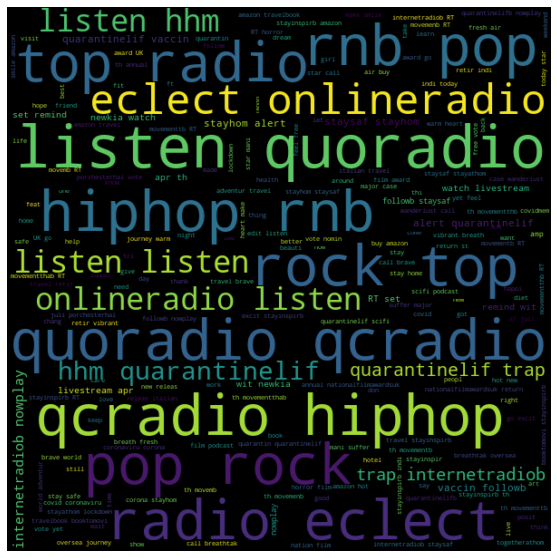

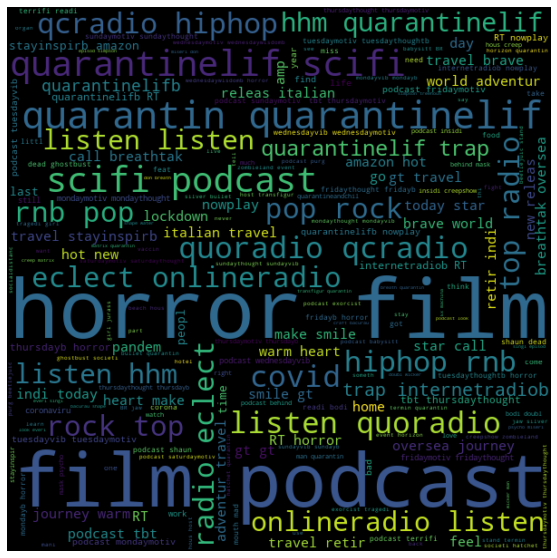

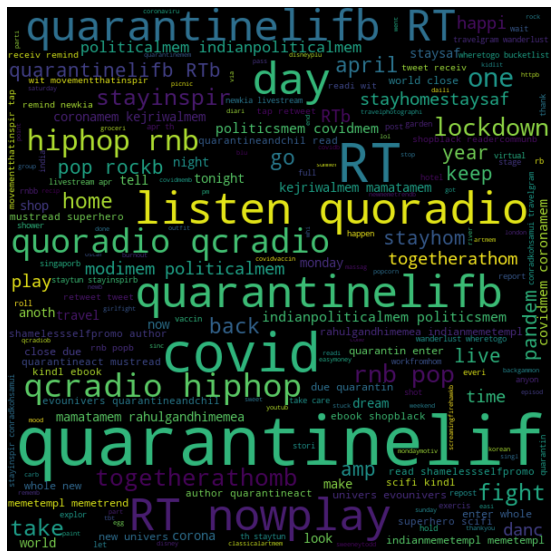

In [6]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Project/latestDataSet/Final/group3.csv',encoding = 'ISO-8859-1')
#full_text is fine

df_copy = df
print(len(df_copy))
serlis=df_copy.duplicated().tolist()
print(serlis.count(True)) #7479

serlis=df_copy.duplicated(['full_text']).tolist()
print(serlis.count(True))

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')


import pandas as pd
import re
import time
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

pstem = PorterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def clean_df(df_copy):
    
    #DROPS
    #CHOOSE EITHER TO DROP ALL-ROW DUPLICATES OR FULL_TEXT DUPLICATES
    df_copy=df_copy.drop_duplicates(['full_text']) #3377 left after this
    df_copy=df_copy.reset_index(drop=True)
    df_copy=df_copy.drop(['place','coordinates','geo','id_str'],axis=1)
    #df_copy=
    
    # BASIC CLEANING FUNCTION
    for i in range(len(df_copy)):
        txt = df_copy.loc[i]["full_text"]
        txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#username-tags
        txt=re.sub(r'^[RT]+','',txt)#RT-tags
        txt = re.sub(r"\\x[a-z0-9]*|\\n|https:[/\.a-zA-Z0-9]*", " ", txt)
        txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#URLs
        txt=re.sub("[^a-zA-Z]", " ",txt)#hashtags
        df_copy.at[i,"full_text"]=txt
    #POS-TAGGING AND SENTIMENT SCORE
    li_swn=[]
    li_swn_pos=[]
    li_swn_neg=[]
    missing_words=[]
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tagged_sent = pos_tag(tokens)
        store_it = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tagged_sent]
        #print("Tagged Parts of Speech:",store_it)

        pos_total=0
        neg_total=0
        for word,tag in store_it:
            if(tag=='NOUN'):
                tag='n'
            elif(tag=='VERB'):
                tag='v'
            elif(tag=='ADJ'):
                tag='a'
            elif(tag=='ADV'):
                tag = 'r'
            else:
                tag='nothing'

            if(tag!='nothing'):   
                concat = word+'.'+tag+'.01'
                # print(concat)
                # print(this_word_pos=swn.senti_synset(concat).pos_score())
                try:
                    this_word_pos=swn.senti_synset(concat).pos_score()
                    this_word_neg=swn.senti_synset(concat).neg_score()
                    # print(word,tag,':',this_word_pos,this_word_neg)
                except Exception as e:
                    wor = lem.lemmatize(word)
                    concat = wor+'.'+tag+'.01'
                    # Checking if there's a possiblity of lemmatized word be accepted into SWN corpus
                    try:
                        this_word_pos=swn.senti_synset(concat).pos_score()
                        this_word_neg=swn.senti_synset(concat).neg_score()
                    except Exception as e:
                        wor = pstem.stem(word)
                        concat = wor+'.'+tag+'.01'
                        # Checking if there's a possiblity of lemmatized word be accepted
                        try:
                            this_word_pos=swn.senti_synset(concat).pos_score()
                            this_word_neg=swn.senti_synset(concat).neg_score()
                        except:
                            missing_words.append(word) 
                            continue
                pos_total+=this_word_pos
                neg_total+=this_word_neg
        li_swn_pos.append(pos_total)
        li_swn_neg.append(neg_total)

        if(pos_total!=0 or neg_total!=0):
            if(pos_total>neg_total):
                li_swn.append(1)
            else:
                li_swn.append(-1)
        else:
            li_swn.append(0)
    # end-of pos-tagging&sentiment
    
    #3-rd for loop    
    #LEMMATIZING,STEMMING,STOP-WORDS
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        for j in range(len(tokens)):
            tokens[j] = lem.lemmatize(tokens[j])
            tokens[j] = pstem.stem(tokens[j])

        tokens_sent=' '.join(tokens)
        df_copy.at[i,"full_text"] = tokens_sent
        
    df_copy.insert(5,"pos_score",li_swn_pos,True)
    df_copy.insert(6,"neg_score",li_swn_neg,True)
    df_copy.insert(7,"sent_score",li_swn,True) 
    return df_copy

st=time.time()
df_copy = clean_df(df_copy)
end=time.time()
print(end-st)#

df_copy.to_csv('useit_all.csv',index=False)
import pandas as pd
df_copy = pd.read_csv('useit_all.csv',index_col=False)
from wordcloud import WordCloud
import math
import matplotlib.pyplot as plt

# GENERATE POSITIVE TEXT,NEGATIVE TEXT,NEUTRAL TEXT FOR DATA-VISUALISATION
pos_text=""
neg_text=""
neut_text=""

for i in range(len(df_copy.index)):
  if(type(df_copy.loc[i]["full_text"])==type("word")):
    if(df_copy.loc[i]["sent_score"]==1):
        pos_text+=df_copy.loc[i]["full_text"]
    elif(df_copy.loc[i]["sent_score"]==-1):
        neg_text+=df_copy.loc[i]["full_text"]
    else:
        # print(df_copy.loc[i]["full_text"])
        neut_text+=df_copy.loc[i]["full_text"]

list_text = [pos_text,neg_text,neut_text]

i=0
for txt in list_text:
    i+=1
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.savefig('group3'+str(i)+'.png')
    plt.show()

#REFERENCE https://github.com/SivaAndMe/Coarse-grained-Sentiment-Analysis-on-Swachh-Bharat-using-Tweets

GeoBased Analysis

In [ ]:
!pip install geopandas

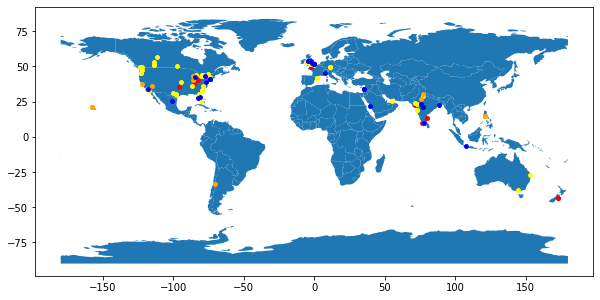

In [4]:
import pandas as pd
import json, re
df = pd.read_csv('/content/drive/MyDrive/Project/latestDataSet/Final/group1.csv',encoding = 'ISO-8859-1')
myLocation = []
df_copy = df
f = open('/content/drive/MyDrive/Project/latestDataSet/GeoData/group1_Geo.txt', 'w')

for i in range(len(df_copy)):
  if(pd.isna(df_copy.loc[i]["coordinates"])):
    pass
  else:
    dict_coord = json.loads(df_copy.loc[i]["coordinates"].replace("'", '"'))
    name = re.findall(r"name='[A-Za-z \.]*'", df_copy.loc[i]["place"])
    country = re.findall(r"country='[A-Za-z \.]*'", df_copy.loc[i]["place"])
    entry = '1' + ',' + str(dict_coord["coordinates"][0]) + ',' + str(dict_coord["coordinates"][1]) +  ',' + name[0][6:-1] + ',' + country[0][9:-1] + "\n"
    f.write(entry)
f.close()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

f = open("/content/drive/MyDrive/Project/latestDataSet/GeoData/group1_Geo.txt", 'r')
pairs = []
d = []
for line in f:
  entry = line.split(',')
  d.append([float(entry[1]), float(entry[2]), int(entry[0])])
  pairs.append([entry[4][:-1], int(entry[0])])
data = np.array(d)
dataarr1 = [[data[i,0],data[i,1]] for i in range(len(data))]

f = open("/content/drive/MyDrive/Project/latestDataSet/GeoData/group2_Geo.txt", 'r')
d = []
for line in f:
  entry = line.split(',')
  d.append([float(entry[1]), float(entry[2]), int(entry[0])])
  pairs.append([entry[4][:-1], int(entry[0])])
data = np.array(d)
dataarr2 = [[data[i,0],data[i,1]] for i in range(len(data))]

f = open("/content/drive/MyDrive/Project/latestDataSet/GeoData/group3_Geo.txt", 'r')
d = []
for line in f:
  entry = line.split(',')
  d.append([float(entry[1]), float(entry[2]), int(entry[0])])
  pairs.append([entry[4][:-1], int(entry[0])])
data = np.array(d)
dataarr3 = [[data[i,0],data[i,1]] for i in range(len(data))]

f = open("/content/drive/MyDrive/Project/latestDataSet/GeoData/group4_Geo.txt", 'r')
d = []
for line in f:
  entry = line.split(',')
  d.append([float(entry[1]), float(entry[2]), int(entry[0])])
  pairs.append([entry[4][:-1], int(entry[0])])
data = np.array(d)
dataarr4 = [[data[i,0],data[i,1]] for i in range(len(data))]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))

df = pd.DataFrame(dataarr1, columns = ['Longitude', 'Latitude'])
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf1 = GeoDataFrame(df, geometry=geometry)   
gdf1.plot(ax=ax, marker='o', color='red', markersize=15);

df = pd.DataFrame(dataarr2, columns = ['Longitude', 'Latitude'])
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf2 = GeoDataFrame(df, geometry=geometry)   
gdf2.plot(ax=ax, marker='o', color='yellow', markersize=15);

df = pd.DataFrame(dataarr3, columns = ['Longitude', 'Latitude'])
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf3 = GeoDataFrame(df, geometry=geometry)   
gdf3.plot(ax=ax, marker='o', color='orange', markersize=15);

df = pd.DataFrame(dataarr4, columns = ['Longitude', 'Latitude'])
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf4 = GeoDataFrame(df, geometry=geometry)   
gdf4.plot(ax=ax, marker='o', color='blue', markersize=15);